In [218]:
import pandas as pd
import json
from datetime import datetime
with open('final_data.json', 'r', encoding='utf-8') as f:
    data_raw = json.load(f)
df = pd.DataFrame(data_raw)


# Return the Unix timestamp

df['month_release'] =  pd.to_datetime(df['publish_time']).dt.month
with open('track_base_in4.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

track_base_in4 = {}

for track in data:
    id_artist = track['id_artist']
    popularity_track = track['popularity_track']
    duration_ms = track['duration_ms']
    
    track_base_in4[id_artist] = {
        'popularity_track': popularity_track,
        'duration_ms': duration_ms
    }

def conmeo(row):
    artist_id = row['id_artist']
    if artist_id in track_base_in4:
        row['popularity_track'] = track_base_in4[artist_id]['popularity_track']
        row['duration_ms'] = track_base_in4[artist_id]['duration_ms']
    else:
        row['popularity_track'] = None
        row['duration_ms'] = None
    return row

df = df.apply(conmeo, axis=1)
df = df.dropna()
df['genres'] = df['genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
df['publish_time'] = df['publish_time'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').timestamp())
df.head()

/tmp/ipykernel_897609/2354891487.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['month_release'] =  pd.to_datetime(df['publish_time']).dt.month


,id_track,name_track,num_samples,end_of_fade_in,start_of_fade_out,loudness,tempo,time_signature,key,mode,...,viewCount,likeCount,commentCount,followers,genres,name,popularity,month_release,popularity_track,duration_ms
0,7iQXYTyuG13aoeHxGG28Nh,PERRO NEGRO,3589034,0.00000,162.76797,-2.248,96.057,4,5,1,...,95171611,612182,12181,85858677.0,reggaeton,Bad Bunny,95.0,10.0,81.0,245939.0
1,0eeX8L0DWvGth1F6xVkvv7,ADIVINO,6144102,0.00000,274.80817,-2.400,117.994,4,10,0,...,37514149,299173,9044,85858677.0,reggaeton,Bad Bunny,95.0,4.0,81.0,245939.0
2,2yzshFeBIwH8tWIqHEFLeD,un x100to,4290120,0.19732,186.35754,-4.089,83.827,4,9,1,...,867036537,3791052,79393,85858677.0,reggaeton,Bad Bunny,95.0,4.0,81.0,245939.0
3,0fea68AdmYNygeTGI4RC18,LA CANCIÓN,5348742,0.36844,238.14966,-5.795,176.088,4,7,1,...,765861885,3132203,56728,85858677.0,reggaeton,Bad Bunny,95.0,10.0,81.0,245939.0
4,6Sq7ltF9Qa7SNFBsV5Cogx,Me Porto Bonito,3937412,0.20934,178.56744,-5.105,92.005,4,1,0,...,953533695,4561442,76914,85858677.0,reggaeton,Bad Bunny,95.0,6.0,81.0,245939.0


In [219]:
from sklearn.preprocessing import LabelEncoder
df['genres'] = LabelEncoder().fit_transform(df['genres'])

In [220]:
df.columns

Index(['id_track', 'name_track', 'num_samples', 'end_of_fade_in',
       'start_of_fade_out', 'loudness', 'tempo', 'time_signature', 'key',
       'mode', 'id_artist', 'publish_time', 'viewCount', 'likeCount',
       'commentCount', 'followers', 'genres', 'name', 'popularity',
       'month_release', 'popularity_track', 'duration_ms'],
      dtype='object')

In [221]:
target_column = 'popularity_track'
feature_columns = df.columns[~df.columns.isin([target_column, 'id_track', 'name_track', 'name', 'id_artist'])].tolist()
print(len(feature_columns))
feature_columns

17


['num_samples',
 'end_of_fade_in',
 'start_of_fade_out',
 'loudness',
 'tempo',
 'time_signature',
 'key',
 'mode',
 'publish_time',
 'viewCount',
 'likeCount',
 'commentCount',
 'followers',
 'genres',
 'popularity',
 'month_release',
 'duration_ms']

In [222]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [223]:
import joblib
scaler = MinMaxScaler(feature_range=(0, 1))
df[feature_columns] = scaler.fit_transform(df[feature_columns])
df[target_column] = df[[target_column]] / 100

joblib.dump(scaler, 'scaler.pkl')
# loaded_scaler = joblib.load('scaler.pkl')

['scaler.pkl']

In [224]:
dataX = df[feature_columns]
dataY = df['popularity_track']

In [225]:
dataY.shape

(3588,)

In [226]:
training_size = int(len(dataX) * 0.9)
test_size = len(dataX) - training_size
X_train, X_test = dataX[0:training_size], dataX[training_size:len(df)]
y_train, y_test = dataY[0:training_size], dataY[training_size:len(df)]

In [227]:
len(y_train)

3229

Mean Squared Error: 0.0030482273046363944
R-squared: 0.9228193169748483


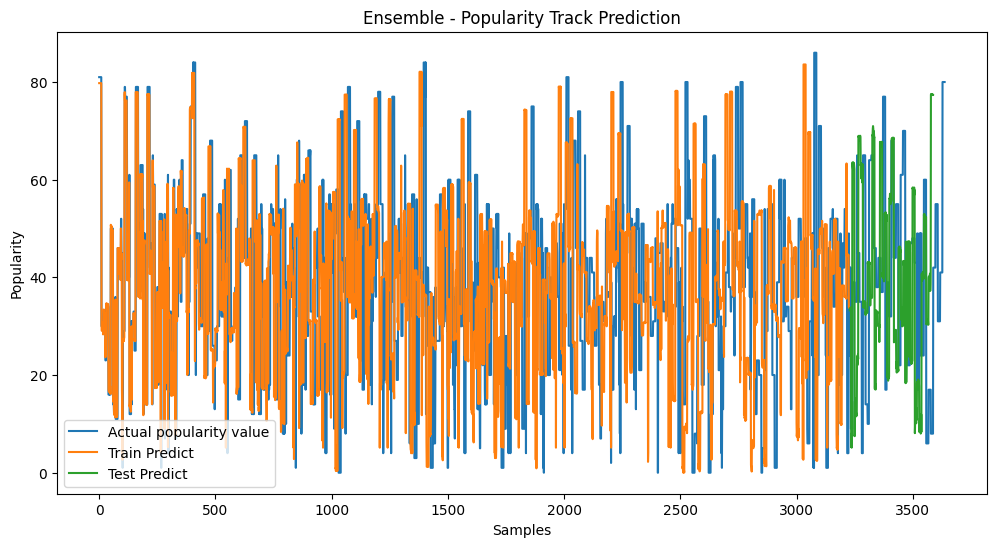

In [235]:
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=10)
rf_model = RandomForestRegressor(n_estimators=10)

stack_model = StackingRegressor(
    estimators=[('rf', rf_model),('rf1', rf_model), ('xgb', xgb_model)],
    final_estimator=LinearRegression()
)
stack_model.fit(X_train, y_train)
test_predict = stack_model.predict(X_test)
train_predict = stack_model.predict(X_train)

mse = mean_squared_error(y_test, test_predict)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, test_predict)
print(f'R-squared: {r2}')

testPredictPlot = np.empty_like(dataY)
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict):len(dataY)] = test_predict
sorted_indices = np.argsort(dataY)
plt.figure(figsize=(12, 6))
plt.plot(dataY*100, label='Actual popularity value')
plt.plot(train_predict * 100, label='Train Predict')
plt.plot(testPredictPlot * 100, label='Test Predict')
plt.title('Ensemble - Popularity Track Prediction')
plt.xlabel('Samples')
plt.ylabel('Popularity')
plt.legend()
plt.show()

In [245]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

rf = RandomForestRegressor(random_state=0)

param_grid = {
    'n_estimators': [5, 10, 20, 30, 40],          
    'max_depth': [None, 10, 20, 30],          
    'min_samples_split': [2, 5, 10],          
    'min_samples_leaf': [1, 2, 4],          
    'max_features': [None,'sqrt', 'log2']  
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, n_jobs=-1, verbose=0)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse:.4f}")


Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 40}
Mean Squared Error on Test Set: 0.0030


In [246]:
from sklearn.metrics import mean_squared_error, r2_score

best_rf.fit(X_train, y_train)
train_predict = best_rf.predict(X_train)
test_predict = best_rf.predict(X_test)

mse = mean_squared_error(y_test, test_predict)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, test_predict)
print(f'R-squared: {r2}')



Mean Squared Error: 0.002950582485760218
R-squared: 0.9252916699398873


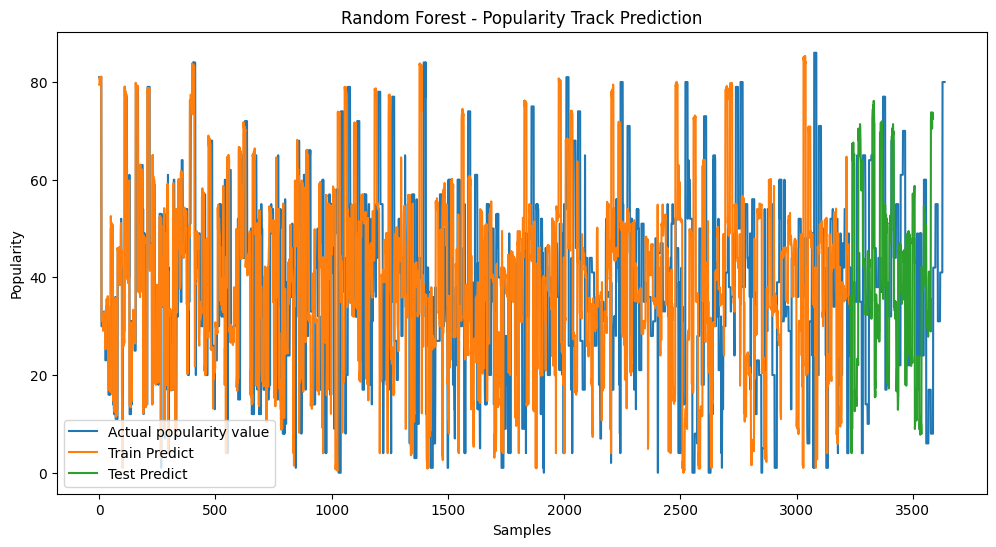

In [247]:
testPredictPlot = np.empty_like(dataY)
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict):len(dataY)] = test_predict
sorted_indices = np.argsort(dataY)
plt.figure(figsize=(12, 6))
plt.plot(dataY* 100, label='Actual popularity value')
plt.plot(train_predict* 100, label='Train Predict')
plt.plot(testPredictPlot* 100, label='Test Predict')
plt.title('Random Forest - Popularity Track Prediction')
plt.xlabel('Samples')
plt.ylabel('Popularity')
plt.legend()
plt.show()

In [232]:
import xgboost as xg
xgb_r = xg.XGBRegressor(n_estimators = 10, seed = 123)
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [233]:
from sklearn.metrics import mean_squared_error, r2_score

train_predict = xgb_r.predict(X_train)
test_predict = xgb_r.predict(X_test)

mse = mean_squared_error(y_test, test_predict)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, test_predict)
print(f'R-squared: {r2}')

Mean Squared Error: 0.003509433199622431
R-squared: 0.9111416491263561


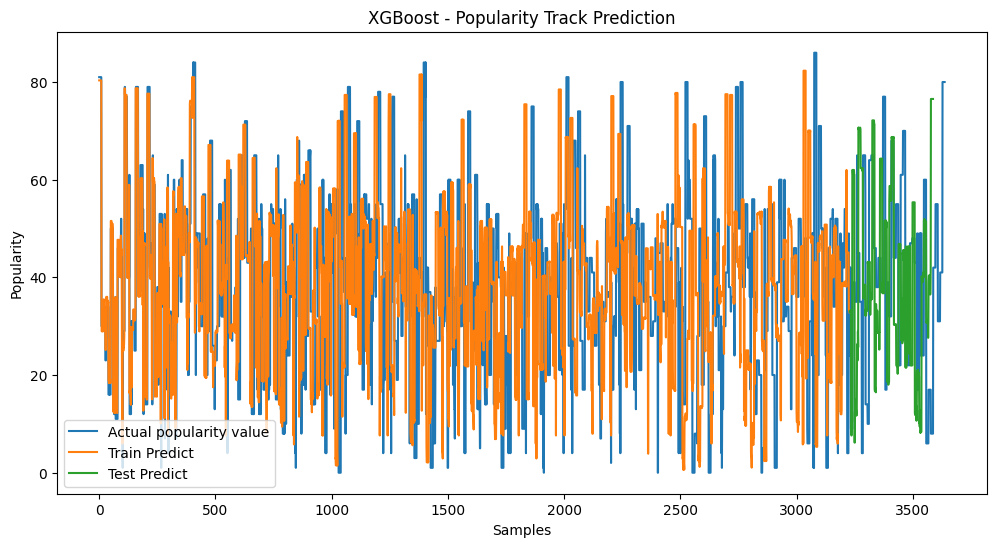

In [234]:
testPredictPlot = np.empty_like(dataY)
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict):len(dataY)] = test_predict

plt.figure(figsize=(12, 6))
plt.plot(dataY* 100, label='Actual popularity value')
plt.plot(train_predict* 100, label='Train Predict')
plt.plot(testPredictPlot* 100, label='Test Predict')
plt.title('XGBoost - Popularity Track Prediction')
plt.xlabel('Samples')
plt.ylabel('Popularity')
plt.legend()
plt.show()